# train.ipynb: 用所有的训练集训练决策树
这里需要用到预处理过的数据，以减少代码运算时间。请先跑`waveform.py`。

In [1]:
import multiprocessing
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression 
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包

`waveform.py`预处理后的数据在./train中，文件名格式为`f"final_{i}_wf.h5"`

In [2]:
trainPathRoot = './data/final-'
processedPathRoot = './train/final_'

从预处理的数据中，读取训练两个训练集需要的原始数据，并将18个训练集的数据拼接起来。
1. `intTrainWF`: 波形积分
2. `pointsPerTrainWF`: 超过阈值的点数
3. `pePerTrainWFCalc`: 每个波形对应的PE数计算值
4. `meanPeTimePerTrainWF`: 每个波形对应的PETime的手算平均值
5. `pePerTrainWF`: 每个波形对应的PE数真值
6. `wfIndices`: (n+1,)的ndarray，下标为i表示EventID=i的第一次出现在Waveform表中的下标，下标为n表示Waveform表长度

In [3]:
intTrainWF = np.array([], dtype='<i4') # 读取波形积分
pointsPerTrainWF = np.array([], dtype='<i2') # 读取超过阈值的点数
pePerTrainWFCalc = np.array([], dtype='<i2') # 读取每个波形对应的PE数计算值
meanPeTimePerTrainWF = np.array([], dtype='<f8') # 读取每个波形对应的PETime的手算平均值
pePerTrainWF = np.array([], dtype='<i2') # 读取每个波形对应的PE数真值

wfIndices = np.array([0], dtype=int)
p = np.array([], dtype='<f8')

previousIndex = 0
for i in tqdm(range(2, 20)):
    with h5py.File(f"{processedPathRoot}{i}_wf.h5", 'r') as ipt:
        intTrainWF = np.append(intTrainWF, ipt['Waveform']['intWF'][...])
        pointsPerTrainWF = np.append(pointsPerTrainWF, ipt['Waveform']['pointsPerWF'][...])
        pePerTrainWFCalc = np.append(pePerTrainWFCalc, ipt['Waveform']['pePerWFCalc'][...])
        meanPeTimePerTrainWF = np.append(meanPeTimePerTrainWF, ipt['Waveform']['meanPeTimePerWF'][...])
        pePerTrainWF = np.append(pePerTrainWF, ipt['Waveform']['pePerWF'][...])
        
        wfIndicesChunk = ipt['WfIndices'][...]
        trainPT = loadData(f"./data/final-{i}.h5", 'p')
        
        wfIndices = np.append(wfIndices, np.zeros(trainPT.shape[0]))
        p = np.append(p, np.zeros(trainPT.shape[0]))
        finalIndex = previousIndex + trainPT.shape[0] + 1
        wfIndices[previousIndex:finalIndex] = wfIndicesChunk + wfIndices[previousIndex]
        p[previousIndex:(finalIndex-1)] = trainPT['p']
        previousIndex = finalIndex-1

  6%|▌         | 1/18 [00:00<00:11,  1.53it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


 11%|█         | 2/18 [00:01<00:10,  1.49it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform


 17%|█▋        | 3/18 [00:02<00:10,  1.49it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9009875,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5987414,), type "|V2008"> Waveform /Waveform


 22%|██▏       | 4/18 [00:02<00:10,  1.40it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9147704,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6004696,), type "|V2008"> Waveform /Waveform


 28%|██▊       | 5/18 [00:03<00:09,  1.35it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9262473,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6115519,), type "|V2008"> Waveform /Waveform


 33%|███▎      | 6/18 [00:04<00:08,  1.36it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9216927,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6075119,), type "|V2008"> Waveform /Waveform


 39%|███▉      | 7/18 [00:04<00:07,  1.44it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9103034,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5990370,), type "|V2008"> Waveform /Waveform


 44%|████▍     | 8/18 [00:05<00:06,  1.47it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9139087,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965634,), type "|V2008"> Waveform /Waveform


 50%|█████     | 9/18 [00:06<00:06,  1.47it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9067611,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5965655,), type "|V2008"> Waveform /Waveform


 56%|█████▌    | 10/18 [00:06<00:05,  1.42it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219415,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039820,), type "|V2008"> Waveform /Waveform


 61%|██████    | 11/18 [00:07<00:05,  1.39it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9141287,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5995751,), type "|V2008"> Waveform /Waveform


 67%|██████▋   | 12/18 [00:08<00:04,  1.34it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9157071,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5984516,), type "|V2008"> Waveform /Waveform


 72%|███████▏  | 13/18 [00:09<00:03,  1.28it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9191741,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1998,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6020168,), type "|V2008"> Waveform /Waveform


 78%|███████▊  | 14/18 [00:10<00:03,  1.23it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9143911,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6038985,), type "|V2008"> Waveform /Waveform


 83%|████████▎ | 15/18 [00:11<00:02,  1.18it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9219236,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (1999,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6039233,), type "|V2008"> Waveform /Waveform


 89%|████████▉ | 16/18 [00:12<00:01,  1.13it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9104863,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5981409,), type "|V2008"> Waveform /Waveform


 94%|█████████▍| 17/18 [00:13<00:00,  1.09it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9202609,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6058586,), type "|V2008"> Waveform /Waveform


100%|██████████| 18/18 [00:14<00:00,  1.26it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9261569,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6085040,), type "|V2008"> Waveform /Waveform


下面的代码和`model.ipynb`是完全一样的，除了训练集、验证集大小不一样。

In [9]:
trainDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[:-10000000], pointsPerTrainWF[:-10000000], pePerTrainWFCalc[:-10000000]),
        axis=1
    ),
    label=pePerTrainWF[:-10000000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-10000000:], pointsPerTrainWF[-10000000:], pePerTrainWFCalc[-10000000:]),
        axis=1
    ),
    label=pePerTrainWF[-10000000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWF.bin')
validationDataForPePerWF.save_binary('./train/validPePerWF.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainPePerWF.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


[LightGBM] [Info] Saving data to binary file ./train/validPePerWF.bin


In [10]:
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWF.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWF.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=100,
)
gbmForPePerWF.save_model('model/modelPePerWF.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.465467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.82572
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 1.80789
[3]	valid_0's rmse: 1.79023
[4]	valid_0's rmse: 1.77276
[5]	valid_0's rmse: 1.75547
[6]	valid_0's rmse: 1.73836
[7]	valid_0's rmse: 1.72142
[8]	valid_0's rmse: 1.70466
[9]	valid_0's rmse: 1.68806
[10]	valid_0's rmse: 1.67164
[11]	valid_0's rmse: 1.65539
[12]	valid_0's rmse: 1.6393
[13]	valid_0's rmse: 1.62338
[14]	valid_0's rmse: 1.60763
[15]	valid_0's rmse: 1.59203
[16]	valid_0's rmse: 1.5766
[17]	valid_0's rmse: 1.56132
[18]	valid_0's rmse: 1.54621
[19]	valid_0's rmse: 1.53124
[20]	valid_0's rmse: 1.51644
[21]	valid_0's rmse: 1.50178
[22]	valid_0's rmse: 1.48728
[23]	valid_0's rmse: 1.47293
[24]	valid_0's rmse: 1.45873
[25]	valid_0's rmse: 1.4

[263]	valid_0's rmse: 0.306831
[264]	valid_0's rmse: 0.306286
[265]	valid_0's rmse: 0.305752
[266]	valid_0's rmse: 0.305227
[267]	valid_0's rmse: 0.304712
[268]	valid_0's rmse: 0.304206
[269]	valid_0's rmse: 0.303709
[270]	valid_0's rmse: 0.303222
[271]	valid_0's rmse: 0.302743
[272]	valid_0's rmse: 0.302273
[273]	valid_0's rmse: 0.301812
[274]	valid_0's rmse: 0.30136
[275]	valid_0's rmse: 0.300916
[276]	valid_0's rmse: 0.30048
[277]	valid_0's rmse: 0.300052
[278]	valid_0's rmse: 0.299632
[279]	valid_0's rmse: 0.29922
[280]	valid_0's rmse: 0.298815
[281]	valid_0's rmse: 0.298418
[282]	valid_0's rmse: 0.298029
[283]	valid_0's rmse: 0.297646
[284]	valid_0's rmse: 0.297271
[285]	valid_0's rmse: 0.296903
[286]	valid_0's rmse: 0.296542
[287]	valid_0's rmse: 0.296188
[288]	valid_0's rmse: 0.29584
[289]	valid_0's rmse: 0.295498
[290]	valid_0's rmse: 0.295164
[291]	valid_0's rmse: 0.294835
[292]	valid_0's rmse: 0.294513
[293]	valid_0's rmse: 0.294197
[294]	valid_0's rmse: 0.293886
[295]	valid_

[529]	valid_0's rmse: 0.278409
[530]	valid_0's rmse: 0.278406
[531]	valid_0's rmse: 0.278404
[532]	valid_0's rmse: 0.278402
[533]	valid_0's rmse: 0.278399
[534]	valid_0's rmse: 0.278397
[535]	valid_0's rmse: 0.278395
[536]	valid_0's rmse: 0.278392
[537]	valid_0's rmse: 0.27839
[538]	valid_0's rmse: 0.278388
[539]	valid_0's rmse: 0.278386
[540]	valid_0's rmse: 0.278384
[541]	valid_0's rmse: 0.278382
[542]	valid_0's rmse: 0.27838
[543]	valid_0's rmse: 0.278378
[544]	valid_0's rmse: 0.278376
[545]	valid_0's rmse: 0.278374
[546]	valid_0's rmse: 0.278373
[547]	valid_0's rmse: 0.278371
[548]	valid_0's rmse: 0.278369
[549]	valid_0's rmse: 0.278368
[550]	valid_0's rmse: 0.278366
[551]	valid_0's rmse: 0.278364
[552]	valid_0's rmse: 0.278363
[553]	valid_0's rmse: 0.278361
[554]	valid_0's rmse: 0.27836
[555]	valid_0's rmse: 0.278358
[556]	valid_0's rmse: 0.278357
[557]	valid_0's rmse: 0.278356
[558]	valid_0's rmse: 0.278354
[559]	valid_0's rmse: 0.278353
[560]	valid_0's rmse: 0.278352
[561]	valid

In [13]:
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWF.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)

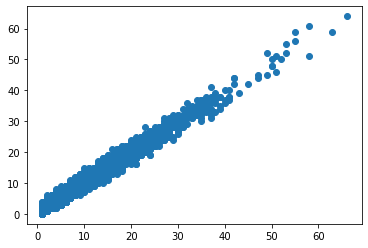

In [32]:
model = LinearRegression()
model.fit(intTrainWF.reshape(-1, 1), pePerTrainWF)
pePerTrainWFInt = np.round(model.predict(intTrainWF.reshape(-1,1)))
plt.scatter(pePerTrainWFInt[:600000], pePerTrainWF[:600000])
plt.show()

In [41]:
print(model.coef_)
print(model.intercept_)

[0.00651683]
0.5644330147776138


In [4]:
# splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1].astype(int))
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1].astype(int))
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)

100%|██████████| 35996/35996 [00:06<00:00, 5489.25it/s]


In [5]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-3600], peMean[:-3600], peStd[:-3600], peTimeMean[:-3600], peTimeStd[:-3600]),
        axis=1
    ),
    label=p[:-3600]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-3600:], peMean[-3600:], peStd[-3600:], peTimeMean[-3600:], peTimeStd[-3600:]),
        axis=1
    ),
    label=p[-3600:],
    reference=trainDataForP
)
trainDataForP.save_binary('./train/trainDataForP.bin')
validationDataForP.save_binary('./train/validDataForP.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainDataForP.bin
[LightGBM] [Info] Saving data to binary file ./train/validDataForP.bin


/home/zhaohaimeng/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')


In [6]:
trainDataForP = lgb.Dataset('./train/trainDataForP.bin')
validationDataForP = lgb.Dataset('./train/validDataForP.bin')

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**15,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 10,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('model/modelPCalc.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 6.20221	valid_0's custom: 5.47572
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 6.19602	valid_0's custom: 5.4648
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.18984	valid_0's custom: 5.45389
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.18367	valid_0's custom: 5.44301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's rmse: 5.81271	valid_0's custom: 4.8091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's rmse: 5.80691	valid_0's custom: 4.7995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's rmse: 5.80112	valid_0's custom: 4.78992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's rmse: 5.79534	valid_0's custom: 4.78037
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's rmse: 5.78956	valid_0's custom: 4.77083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's rmse: 5.78379	valid_0's custom: 4.76131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's rmse: 5.77802	valid_0's custom: 4.75182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's rm

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's rmse: 5.40443	valid_0's custom: 4.15672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's rmse: 5.39905	valid_0's custom: 4.14843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's rmse: 5.39366	valid_0's custom: 4.14015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's rmse: 5.38828	valid_0's custom: 4.13189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's rmse: 5.38291	valid_0's custom: 4.12365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's rmse: 5.37755	valid_0's custom: 4.11542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's rmse: 5.37219	valid_0's custom: 4.10722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's rmse: 5.07027	valid_0's custom: 3.65813
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's rmse: 5.06522	valid_0's custom: 3.65084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's rmse: 5.06017	valid_0's custom: 3.64355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's rmse: 5.05513	valid_0's custom: 3.63629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's rmse: 5.05009	valid_0's custom: 3.62903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's rmse: 5.04506	valid_0's custom: 3.6218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's rmse: 5.04003	valid_0's custom: 3.61457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's rmse: 4.70968	valid_0's custom: 3.15581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[278]	valid_0's rmse: 4.70499	valid_0's custom: 3.14952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[279]	valid_0's rmse: 4.70031	valid_0's custom: 3.14324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[280]	valid_0's rmse: 4.69562	valid_0's custom: 3.13698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[281]	valid_0's rmse: 4.69095	valid_0's custom: 3.13073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[282]	valid_0's rmse: 4.68628	valid_0's custom: 3.12449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's rmse: 4.68161	valid_0's custom: 3.11826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's rmse: 4.37499	valid_0's custom: 2.72276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's rmse: 4.37063	valid_0's custom: 2.71733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's rmse: 4.36628	valid_0's custom: 2.71192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[354]	valid_0's rmse: 4.36193	valid_0's custom: 2.70652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[355]	valid_0's rmse: 4.35759	valid_0's custom: 2.70112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[356]	valid_0's rmse: 4.35325	valid_0's custom: 2.69574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[357]	valid_0's rmse: 4.34892	valid_0's custom: 2.69038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[358]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's rmse: 4.07229	valid_0's custom: 2.35865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's rmse: 4.06824	valid_0's custom: 2.35395
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's rmse: 4.06419	valid_0's custom: 2.34927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's rmse: 4.06015	valid_0's custom: 2.34459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	valid_0's rmse: 4.05611	valid_0's custom: 2.33992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[428]	valid_0's rmse: 4.05207	valid_0's custom: 2.33526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's rmse: 4.04804	valid_0's custom: 2.33061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[430]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	valid_0's rmse: 3.79066	valid_0's custom: 2.04338
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's rmse: 3.78689	valid_0's custom: 2.03932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's rmse: 3.78313	valid_0's custom: 2.03526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's rmse: 3.77937	valid_0's custom: 2.03121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's rmse: 3.77561	valid_0's custom: 2.02716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 3.77185	valid_0's custom: 2.02313
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's rmse: 3.7681	valid_0's custom: 2.0191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	vali

[568]	valid_0's rmse: 3.52515	valid_0's custom: 1.76689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's rmse: 3.52164	valid_0's custom: 1.76337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's rmse: 3.51814	valid_0's custom: 1.75987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's rmse: 3.51465	valid_0's custom: 1.75637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[572]	valid_0's rmse: 3.51115	valid_0's custom: 1.75288
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[573]	valid_0's rmse: 3.50766	valid_0's custom: 1.74939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[574]	valid_0's rmse: 3.50418	valid_0's custom: 1.74591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's rmse: 3.50069	valid_0's custom: 1.74244
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's rmse: 3.28168	valid_0's custom: 1.53102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's rmse: 3.27842	valid_0's custom: 1.52798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's rmse: 3.27516	valid_0's custom: 1.52494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's rmse: 3.27191	valid_0's custom: 1.52191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's rmse: 3.26866	valid_0's custom: 1.51889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[645]	valid_0's rmse: 3.26542	valid_0's custom: 1.51587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[646]	valid_0's rmse: 3.26217	valid_0's custom: 1.51286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[647]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[708]	valid_0's rmse: 3.06737	valid_0's custom: 1.33739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[709]	valid_0's rmse: 3.06433	valid_0's custom: 1.33473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[710]	valid_0's rmse: 3.06129	valid_0's custom: 1.33208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[711]	valid_0's rmse: 3.05825	valid_0's custom: 1.32943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[712]	valid_0's rmse: 3.05522	valid_0's custom: 1.32679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[713]	valid_0's rmse: 3.05218	valid_0's custom: 1.32416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[714]	valid_0's rmse: 3.04916	valid_0's custom: 1.32153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[715]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[781]	valid_0's rmse: 2.85299	valid_0's custom: 1.15678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[782]	valid_0's rmse: 2.85016	valid_0's custom: 1.15449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[783]	valid_0's rmse: 2.84734	valid_0's custom: 1.15219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[784]	valid_0's rmse: 2.84451	valid_0's custom: 1.14991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[785]	valid_0's rmse: 2.84169	valid_0's custom: 1.14763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[786]	valid_0's rmse: 2.83887	valid_0's custom: 1.14535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[787]	valid_0's rmse: 2.83606	valid_0's custom: 1.14308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[788]	va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[844]	valid_0's rmse: 2.68021	valid_0's custom: 1.02078
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[845]	valid_0's rmse: 2.67755	valid_0's custom: 1.01876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[846]	valid_0's rmse: 2.6749	valid_0's custom: 1.01674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[847]	valid_0's rmse: 2.67225	valid_0's custom: 1.01472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[848]	valid_0's rmse: 2.6696	valid_0's custom: 1.01271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[849]	valid_0's rmse: 2.66696	valid_0's custom: 1.01071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[850]	valid_0's rmse: 2.66431	valid_0's custom: 1.0087
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[851]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[908]	valid_0's rmse: 2.51556	valid_0's custom: 0.899115
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[909]	valid_0's rmse: 2.51307	valid_0's custom: 0.897333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[910]	valid_0's rmse: 2.51058	valid_0's custom: 0.895557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[911]	valid_0's rmse: 2.5081	valid_0's custom: 0.893783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[912]	valid_0's rmse: 2.50562	valid_0's custom: 0.892014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[913]	valid_0's rmse: 2.50314	valid_0's custom: 0.890248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[914]	valid_0's rmse: 2.50066	valid_0's custom: 0.888486
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[972]	valid_0's rmse: 2.36118	valid_0's custom: 0.792056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[973]	valid_0's rmse: 2.35885	valid_0's custom: 0.79049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[974]	valid_0's rmse: 2.35652	valid_0's custom: 0.788926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[975]	valid_0's rmse: 2.35419	valid_0's custom: 0.787366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[976]	valid_0's rmse: 2.35186	valid_0's custom: 0.785808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[977]	valid_0's rmse: 2.34953	valid_0's custom: 0.784255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[978]	valid_0's rmse: 2.34721	valid_0's custom: 0.782705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's rmse: 2.20772	valid_0's custom: 0.692381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's rmse: 2.20554	valid_0's custom: 0.691014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's rmse: 2.20336	valid_0's custom: 0.689649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1043]	valid_0's rmse: 2.20118	valid_0's custom: 0.688286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1044]	valid_0's rmse: 2.19901	valid_0's custom: 0.686928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1045]	valid_0's rmse: 2.19684	valid_0's custom: 0.685571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1046]	valid_0's rmse: 2.19467	valid_0's custom: 0.684217
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1110]	valid_0's rmse: 2.06034	valid_0's custom: 0.602985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1111]	valid_0's rmse: 2.05831	valid_0's custom: 0.601797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1112]	valid_0's rmse: 2.05628	valid_0's custom: 0.600611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1113]	valid_0's rmse: 2.05426	valid_0's custom: 0.599429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1114]	valid_0's rmse: 2.05223	valid_0's custom: 0.598247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1115]	valid_0's rmse: 2.05021	valid_0's custom: 0.597068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1116]	valid_0's rmse: 2.04819	valid_0's custom: 0.595891
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1180]	valid_0's rmse: 1.92303	valid_0's custom: 0.525282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1181]	valid_0's rmse: 1.92114	valid_0's custom: 0.524248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1182]	valid_0's rmse: 1.91925	valid_0's custom: 0.523218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1183]	valid_0's rmse: 1.91736	valid_0's custom: 0.522189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1184]	valid_0's rmse: 1.91548	valid_0's custom: 0.521162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1185]	valid_0's rmse: 1.91359	valid_0's custom: 0.520138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1186]	valid_0's rmse: 1.91171	valid_0's custom: 0.519114
[LightGBM] [Warning] No further splits with positive gain, best gain:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1250]	valid_0's rmse: 1.79513	valid_0's custom: 0.457731
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1251]	valid_0's rmse: 1.79337	valid_0's custom: 0.456832
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1252]	valid_0's rmse: 1.7916	valid_0's custom: 0.455935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1253]	valid_0's rmse: 1.78985	valid_0's custom: 0.455041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1254]	valid_0's rmse: 1.78809	valid_0's custom: 0.454148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1255]	valid_0's rmse: 1.78633	valid_0's custom: 0.453256
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's rmse: 1.78458	valid_0's custom: 0.452367
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1320]	valid_0's rmse: 1.67599	valid_0's custom: 0.399001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1321]	valid_0's rmse: 1.67435	valid_0's custom: 0.39822
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1322]	valid_0's rmse: 1.67272	valid_0's custom: 0.397441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1323]	valid_0's rmse: 1.67108	valid_0's custom: 0.396663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1324]	valid_0's rmse: 1.66944	valid_0's custom: 0.395888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1325]	valid_0's rmse: 1.66781	valid_0's custom: 0.395113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1326]	valid_0's rmse: 1.66617	valid_0's custom: 0.39434
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1390]	valid_0's rmse: 1.56509	valid_0's custom: 0.347959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1391]	valid_0's rmse: 1.56356	valid_0's custom: 0.34728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1392]	valid_0's rmse: 1.56204	valid_0's custom: 0.346603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1393]	valid_0's rmse: 1.56051	valid_0's custom: 0.345927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1394]	valid_0's rmse: 1.55899	valid_0's custom: 0.345252
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1395]	valid_0's rmse: 1.55747	valid_0's custom: 0.344579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1396]	valid_0's rmse: 1.55595	valid_0's custom: 0.343907
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1460]	valid_0's rmse: 1.46184	valid_0's custom: 0.303588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1461]	valid_0's rmse: 1.46041	valid_0's custom: 0.302999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1462]	valid_0's rmse: 1.45899	valid_0's custom: 0.30241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1463]	valid_0's rmse: 1.45757	valid_0's custom: 0.301823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1464]	valid_0's rmse: 1.45616	valid_0's custom: 0.301236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1465]	valid_0's rmse: 1.45474	valid_0's custom: 0.300651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1466]	valid_0's rmse: 1.45333	valid_0's custom: 0.300067
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1523]	valid_0's rmse: 1.37502	valid_0's custom: 0.268638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1524]	valid_0's rmse: 1.37369	valid_0's custom: 0.268119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1525]	valid_0's rmse: 1.37236	valid_0's custom: 0.2676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1526]	valid_0's rmse: 1.37103	valid_0's custom: 0.267082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1527]	valid_0's rmse: 1.3697	valid_0's custom: 0.266565
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1528]	valid_0's rmse: 1.36837	valid_0's custom: 0.266049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1529]	valid_0's rmse: 1.36704	valid_0's custom: 0.265535
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1585]	valid_0's rmse: 1.29494	valid_0's custom: 0.238307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1586]	valid_0's rmse: 1.29369	valid_0's custom: 0.237849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1587]	valid_0's rmse: 1.29244	valid_0's custom: 0.23739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1588]	valid_0's rmse: 1.2912	valid_0's custom: 0.236933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1589]	valid_0's rmse: 1.28995	valid_0's custom: 0.236477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1590]	valid_0's rmse: 1.28871	valid_0's custom: 0.236022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1591]	valid_0's rmse: 1.28746	valid_0's custom: 0.235567
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1650]	valid_0's rmse: 1.2163	valid_0's custom: 0.210299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1651]	valid_0's rmse: 1.21513	valid_0's custom: 0.209897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1652]	valid_0's rmse: 1.21396	valid_0's custom: 0.209494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1653]	valid_0's rmse: 1.2128	valid_0's custom: 0.209093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1654]	valid_0's rmse: 1.21163	valid_0's custom: 0.208692
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1655]	valid_0's rmse: 1.21047	valid_0's custom: 0.208292
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1656]	valid_0's rmse: 1.2093	valid_0's custom: 0.207893
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[1718]	valid_0's rmse: 1.13948	valid_0's custom: 0.184643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1719]	valid_0's rmse: 1.13839	valid_0's custom: 0.184291
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1720]	valid_0's rmse: 1.1373	valid_0's custom: 0.18394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1721]	valid_0's rmse: 1.13621	valid_0's custom: 0.183589
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1722]	valid_0's rmse: 1.13512	valid_0's custom: 0.18324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1723]	valid_0's rmse: 1.13404	valid_0's custom: 0.182891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1724]	valid_0's rmse: 1.13296	valid_0's custom: 0.182543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1725]	valid_0's rmse: 1.13187	valid_0's custom: 0.182195
[LightGBM] [Wa

[1787]	valid_0's rmse: 1.06688	valid_0's custom: 0.161946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1788]	valid_0's rmse: 1.06587	valid_0's custom: 0.16164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1789]	valid_0's rmse: 1.06485	valid_0's custom: 0.161334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1790]	valid_0's rmse: 1.06384	valid_0's custom: 0.161029
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1791]	valid_0's rmse: 1.06283	valid_0's custom: 0.160724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1792]	valid_0's rmse: 1.06182	valid_0's custom: 0.16042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	valid_0's rmse: 1.06082	valid_0's custom: 0.160118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1794]	valid_0's rmse: 1.05981	valid_0's custom: 0.159815
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1860]	valid_0's rmse: 0.995569	valid_0's custom: 0.141113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1861]	valid_0's rmse: 0.994629	valid_0's custom: 0.140848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1862]	valid_0's rmse: 0.993692	valid_0's custom: 0.140584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1863]	valid_0's rmse: 0.992754	valid_0's custom: 0.14032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1864]	valid_0's rmse: 0.991817	valid_0's custom: 0.140057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1865]	valid_0's rmse: 0.990881	valid_0's custom: 0.139794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1866]	valid_0's rmse: 0.989946	valid_0's custom: 0.139532
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1935]	valid_0's rmse: 0.927766	valid_0's custom: 0.122656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1936]	valid_0's rmse: 0.926899	valid_0's custom: 0.122428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1937]	valid_0's rmse: 0.926032	valid_0's custom: 0.122201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1938]	valid_0's rmse: 0.925166	valid_0's custom: 0.121974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1939]	valid_0's rmse: 0.9243	valid_0's custom: 0.121748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1940]	valid_0's rmse: 0.923436	valid_0's custom: 0.121522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1941]	valid_0's rmse: 0.922573	valid_0's custom: 0.121296
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2009]	valid_0's rmse: 0.865939	valid_0's custom: 0.106969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2010]	valid_0's rmse: 0.865136	valid_0's custom: 0.106773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2011]	valid_0's rmse: 0.864334	valid_0's custom: 0.106577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2012]	valid_0's rmse: 0.863533	valid_0's custom: 0.106381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2013]	valid_0's rmse: 0.862733	valid_0's custom: 0.106186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2014]	valid_0's rmse: 0.861934	valid_0's custom: 0.105991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2015]	valid_0's rmse: 0.861135	valid_0's custom: 0.105796
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2083]	valid_0's rmse: 0.808822	valid_0's custom: 0.0934454
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2084]	valid_0's rmse: 0.808081	valid_0's custom: 0.0932761
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2085]	valid_0's rmse: 0.80734	valid_0's custom: 0.093107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2086]	valid_0's rmse: 0.806601	valid_0's custom: 0.0929383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2087]	valid_0's rmse: 0.805863	valid_0's custom: 0.0927701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2088]	valid_0's rmse: 0.805125	valid_0's custom: 0.092602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2089]	valid_0's rmse: 0.804388	valid_0's custom: 0.0924343
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2158]	valid_0's rmse: 0.755434	valid_0's custom: 0.081644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2159]	valid_0's rmse: 0.75475	valid_0's custom: 0.0814982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2160]	valid_0's rmse: 0.754069	valid_0's custom: 0.081353
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2161]	valid_0's rmse: 0.753388	valid_0's custom: 0.081208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2162]	valid_0's rmse: 0.752707	valid_0's custom: 0.0810632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2163]	valid_0's rmse: 0.752027	valid_0's custom: 0.0809188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2164]	valid_0's rmse: 0.751349	valid_0's custom: 0.0807746
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2233]	valid_0's rmse: 0.706281	valid_0's custom: 0.0714977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2234]	valid_0's rmse: 0.705653	valid_0's custom: 0.0713726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2235]	valid_0's rmse: 0.705024	valid_0's custom: 0.0712476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2236]	valid_0's rmse: 0.704397	valid_0's custom: 0.0711228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2237]	valid_0's rmse: 0.703772	valid_0's custom: 0.0709983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2238]	valid_0's rmse: 0.703146	valid_0's custom: 0.0708741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2239]	valid_0's rmse: 0.702521	valid_0's custom: 0.0707502
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2294]	valid_0's rmse: 0.669192	valid_0's custom: 0.0642993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2295]	valid_0's rmse: 0.668605	valid_0's custom: 0.0641888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2296]	valid_0's rmse: 0.668018	valid_0's custom: 0.0640782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2297]	valid_0's rmse: 0.667433	valid_0's custom: 0.0639679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2298]	valid_0's rmse: 0.666848	valid_0's custom: 0.0638577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2299]	valid_0's rmse: 0.666265	valid_0's custom: 0.063748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2300]	valid_0's rmse: 0.665681	valid_0's custom: 0.0636382
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2369]	valid_0's rmse: 0.626975	valid_0's custom: 0.0565795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2370]	valid_0's rmse: 0.626437	valid_0's custom: 0.0564843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2371]	valid_0's rmse: 0.625899	valid_0's custom: 0.0563893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2372]	valid_0's rmse: 0.625362	valid_0's custom: 0.0562945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2373]	valid_0's rmse: 0.624826	valid_0's custom: 0.0562001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2374]	valid_0's rmse: 0.624288	valid_0's custom: 0.0561054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2375]	valid_0's rmse: 0.623754	valid_0's custom: 0.0560113
[LightGBM] [Warning] No further splits with positive ga

[2444]	valid_0's rmse: 0.58823	valid_0's custom: 0.0499428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2445]	valid_0's rmse: 0.587736	valid_0's custom: 0.049861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2446]	valid_0's rmse: 0.587242	valid_0's custom: 0.0497791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2447]	valid_0's rmse: 0.586749	valid_0's custom: 0.0496976
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2448]	valid_0's rmse: 0.586256	valid_0's custom: 0.0496161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2449]	valid_0's rmse: 0.585764	valid_0's custom: 0.049535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2450]	valid_0's rmse: 0.585272	valid_0's custom: 0.0494538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2451]	valid_0's rmse: 0.584782	valid_0's custom: 0.049372

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2506]	valid_0's rmse: 0.558607	valid_0's custom: 0.0451605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2507]	valid_0's rmse: 0.558146	valid_0's custom: 0.0450881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2508]	valid_0's rmse: 0.557684	valid_0's custom: 0.0450157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2509]	valid_0's rmse: 0.557224	valid_0's custom: 0.0449435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2510]	valid_0's rmse: 0.556767	valid_0's custom: 0.0448718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2511]	valid_0's rmse: 0.556308	valid_0's custom: 0.0448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2512]	valid_0's rmse: 0.555849	valid_0's custom: 0.0447282
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2570]	valid_0's rmse: 0.530163	valid_0's custom: 0.0408019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2571]	valid_0's rmse: 0.529735	valid_0's custom: 0.0407381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2572]	valid_0's rmse: 0.529308	valid_0's custom: 0.0406746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2573]	valid_0's rmse: 0.528882	valid_0's custom: 0.0406113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2574]	valid_0's rmse: 0.528454	valid_0's custom: 0.0405476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2575]	valid_0's rmse: 0.528029	valid_0's custom: 0.0404845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2576]	valid_0's rmse: 0.527604	valid_0's custom: 0.0404213
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2637]	valid_0's rmse: 0.50259	valid_0's custom: 0.0368004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2638]	valid_0's rmse: 0.502197	valid_0's custom: 0.036745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2639]	valid_0's rmse: 0.501802	valid_0's custom: 0.0366893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2640]	valid_0's rmse: 0.501407	valid_0's custom: 0.0366337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2641]	valid_0's rmse: 0.501013	valid_0's custom: 0.0365784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2642]	valid_0's rmse: 0.500619	valid_0's custom: 0.0365228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2643]	valid_0's rmse: 0.500228	valid_0's custom: 0.0364679
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2705]	valid_0's rmse: 0.476795	valid_0's custom: 0.0332541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2706]	valid_0's rmse: 0.476431	valid_0's custom: 0.0332055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2707]	valid_0's rmse: 0.476068	valid_0's custom: 0.0331571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2708]	valid_0's rmse: 0.475705	valid_0's custom: 0.0331086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2709]	valid_0's rmse: 0.475342	valid_0's custom: 0.0330601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2710]	valid_0's rmse: 0.474981	valid_0's custom: 0.033012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2711]	valid_0's rmse: 0.47462	valid_0's custom: 0.0329639
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2774]	valid_0's rmse: 0.452728	valid_0's custom: 0.0301167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2775]	valid_0's rmse: 0.452394	valid_0's custom: 0.0300743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2776]	valid_0's rmse: 0.452061	valid_0's custom: 0.0300319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2777]	valid_0's rmse: 0.451728	valid_0's custom: 0.0299898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2778]	valid_0's rmse: 0.451394	valid_0's custom: 0.0299475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2779]	valid_0's rmse: 0.451061	valid_0's custom: 0.0299053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2780]	valid_0's rmse: 0.450729	valid_0's custom: 0.0298633
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2846]	valid_0's rmse: 0.429724	valid_0's custom: 0.0272699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2847]	valid_0's rmse: 0.429419	valid_0's custom: 0.0272331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2848]	valid_0's rmse: 0.429114	valid_0's custom: 0.0271963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2849]	valid_0's rmse: 0.42881	valid_0's custom: 0.0271597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2850]	valid_0's rmse: 0.428506	valid_0's custom: 0.0271231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2851]	valid_0's rmse: 0.428202	valid_0's custom: 0.0270866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2852]	valid_0's rmse: 0.4279	valid_0's custom: 0.0270503
[LightGBM] [Warning] No further splits with positive gain,

[2915]	valid_0's rmse: 0.409558	valid_0's custom: 0.0248963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2916]	valid_0's rmse: 0.409278	valid_0's custom: 0.0248643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2917]	valid_0's rmse: 0.409001	valid_0's custom: 0.0248323
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2918]	valid_0's rmse: 0.408723	valid_0's custom: 0.0248005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2919]	valid_0's rmse: 0.408444	valid_0's custom: 0.0247686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2920]	valid_0's rmse: 0.408167	valid_0's custom: 0.0247368
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2921]	valid_0's rmse: 0.407889	valid_0's custom: 0.0247051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2922]	valid_0's rmse: 0.407613	valid_0's custom: 0.024

[2988]	valid_0's rmse: 0.390115	valid_0's custom: 0.0227183
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2989]	valid_0's rmse: 0.389862	valid_0's custom: 0.0226907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2990]	valid_0's rmse: 0.38961	valid_0's custom: 0.0226631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2991]	valid_0's rmse: 0.389358	valid_0's custom: 0.0226356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2992]	valid_0's rmse: 0.389105	valid_0's custom: 0.0226081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2993]	valid_0's rmse: 0.388852	valid_0's custom: 0.0225806
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2994]	valid_0's rmse: 0.388602	valid_0's custom: 0.0225534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2995]	valid_0's rmse: 0.38835	valid_0's custom: 0.02252

[3061]	valid_0's rmse: 0.372497	valid_0's custom: 0.0208374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3062]	valid_0's rmse: 0.372269	valid_0's custom: 0.0208135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3063]	valid_0's rmse: 0.372039	valid_0's custom: 0.0207896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3064]	valid_0's rmse: 0.37181	valid_0's custom: 0.0207658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3065]	valid_0's rmse: 0.371582	valid_0's custom: 0.0207421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3066]	valid_0's rmse: 0.371353	valid_0's custom: 0.0207184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3067]	valid_0's rmse: 0.371124	valid_0's custom: 0.0206946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3068]	valid_0's rmse: 0.370898	valid_0's custom: 0.0206

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3139]	valid_0's rmse: 0.355528	valid_0's custom: 0.0191088
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3140]	valid_0's rmse: 0.355321	valid_0's custom: 0.0190882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3141]	valid_0's rmse: 0.355117	valid_0's custom: 0.019068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3142]	valid_0's rmse: 0.35491	valid_0's custom: 0.0190475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3143]	valid_0's rmse: 0.354706	valid_0's custom: 0.0190271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3144]	valid_0's rmse: 0.354502	valid_0's custom: 0.0190069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3145]	valid_0's rmse: 0.354298	valid_0's custom: 0.0189866
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3214]	valid_0's rmse: 0.340867	valid_0's custom: 0.0176827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3215]	valid_0's rmse: 0.340682	valid_0's custom: 0.0176652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3216]	valid_0's rmse: 0.340497	valid_0's custom: 0.0176476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3217]	valid_0's rmse: 0.340312	valid_0's custom: 0.01763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3218]	valid_0's rmse: 0.340128	valid_0's custom: 0.0176126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3219]	valid_0's rmse: 0.339945	valid_0's custom: 0.0175953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3220]	valid_0's rmse: 0.33976	valid_0's custom: 0.0175778
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3276]	valid_0's rmse: 0.329927	valid_0's custom: 0.0166602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3277]	valid_0's rmse: 0.32976	valid_0's custom: 0.0166449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3278]	valid_0's rmse: 0.32959	valid_0's custom: 0.0166293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3279]	valid_0's rmse: 0.329421	valid_0's custom: 0.0166138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3280]	valid_0's rmse: 0.329254	valid_0's custom: 0.0165985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3281]	valid_0's rmse: 0.329085	valid_0's custom: 0.016583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3282]	valid_0's rmse: 0.328917	valid_0's custom: 0.0165676
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3338]	valid_0's rmse: 0.319944	valid_0's custom: 0.0157575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3339]	valid_0's rmse: 0.319792	valid_0's custom: 0.0157439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3340]	valid_0's rmse: 0.319637	valid_0's custom: 0.0157302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3341]	valid_0's rmse: 0.319485	valid_0's custom: 0.0157167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3342]	valid_0's rmse: 0.319334	valid_0's custom: 0.0157032
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3343]	valid_0's rmse: 0.319181	valid_0's custom: 0.0156895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3344]	valid_0's rmse: 0.31903	valid_0's custom: 0.0156762
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3402]	valid_0's rmse: 0.310538	valid_0's custom: 0.0149347
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3403]	valid_0's rmse: 0.310398	valid_0's custom: 0.0149227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3404]	valid_0's rmse: 0.310258	valid_0's custom: 0.0149106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3405]	valid_0's rmse: 0.310118	valid_0's custom: 0.0148986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3406]	valid_0's rmse: 0.309978	valid_0's custom: 0.0148867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3407]	valid_0's rmse: 0.30984	valid_0's custom: 0.0148747
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3408]	valid_0's rmse: 0.309701	valid_0's custom: 0.0148628
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3469]	valid_0's rmse: 0.301604	valid_0's custom: 0.0141765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3470]	valid_0's rmse: 0.301477	valid_0's custom: 0.0141658
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3471]	valid_0's rmse: 0.301351	valid_0's custom: 0.0141555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3472]	valid_0's rmse: 0.301224	valid_0's custom: 0.0141449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3473]	valid_0's rmse: 0.301098	valid_0's custom: 0.0141344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3474]	valid_0's rmse: 0.300972	valid_0's custom: 0.0141239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3475]	valid_0's rmse: 0.300847	valid_0's custom: 0.0141135
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3538]	valid_0's rmse: 0.29331	valid_0's custom: 0.0134968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3539]	valid_0's rmse: 0.293197	valid_0's custom: 0.0134875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3540]	valid_0's rmse: 0.293084	valid_0's custom: 0.0134784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3541]	valid_0's rmse: 0.292971	valid_0's custom: 0.0134694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3542]	valid_0's rmse: 0.292858	valid_0's custom: 0.0134604
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3543]	valid_0's rmse: 0.292745	valid_0's custom: 0.0134511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3544]	valid_0's rmse: 0.292632	valid_0's custom: 0.0134421
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3610]	valid_0's rmse: 0.285638	valid_0's custom: 0.0128866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3611]	valid_0's rmse: 0.285536	valid_0's custom: 0.0128787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3612]	valid_0's rmse: 0.285437	valid_0's custom: 0.0128709
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3613]	valid_0's rmse: 0.285337	valid_0's custom: 0.0128633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3614]	valid_0's rmse: 0.285237	valid_0's custom: 0.0128554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3615]	valid_0's rmse: 0.285138	valid_0's custom: 0.0128477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3616]	valid_0's rmse: 0.285039	valid_0's custom: 0.0128399
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3681]	valid_0's rmse: 0.278869	valid_0's custom: 0.0123673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3682]	valid_0's rmse: 0.27878	valid_0's custom: 0.0123606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3683]	valid_0's rmse: 0.278689	valid_0's custom: 0.0123538
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3684]	valid_0's rmse: 0.278599	valid_0's custom: 0.0123471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3685]	valid_0's rmse: 0.278509	valid_0's custom: 0.0123404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3686]	valid_0's rmse: 0.27842	valid_0's custom: 0.0123337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3687]	valid_0's rmse: 0.278331	valid_0's custom: 0.0123269
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3757]	valid_0's rmse: 0.272453	valid_0's custom: 0.0118888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3758]	valid_0's rmse: 0.272374	valid_0's custom: 0.011883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3759]	valid_0's rmse: 0.272295	valid_0's custom: 0.0118773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3760]	valid_0's rmse: 0.272217	valid_0's custom: 0.0118715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3761]	valid_0's rmse: 0.272139	valid_0's custom: 0.0118657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3762]	valid_0's rmse: 0.27206	valid_0's custom: 0.0118598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3763]	valid_0's rmse: 0.271982	valid_0's custom: 0.0118539
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3834]	valid_0's rmse: 0.266777	valid_0's custom: 0.0114748
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3835]	valid_0's rmse: 0.266708	valid_0's custom: 0.0114698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3836]	valid_0's rmse: 0.266641	valid_0's custom: 0.0114649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3837]	valid_0's rmse: 0.266573	valid_0's custom: 0.01146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3838]	valid_0's rmse: 0.266506	valid_0's custom: 0.0114551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3839]	valid_0's rmse: 0.266438	valid_0's custom: 0.0114503
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3840]	valid_0's rmse: 0.26637	valid_0's custom: 0.0114452
[LightGBM] [Warning] No further splits with positive gain,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3913]	valid_0's rmse: 0.261707	valid_0's custom: 0.0111126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3914]	valid_0's rmse: 0.261646	valid_0's custom: 0.0111084
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3915]	valid_0's rmse: 0.261587	valid_0's custom: 0.0111042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3916]	valid_0's rmse: 0.261526	valid_0's custom: 0.0110998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3917]	valid_0's rmse: 0.261467	valid_0's custom: 0.0110957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3918]	valid_0's rmse: 0.261407	valid_0's custom: 0.0110913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3919]	valid_0's rmse: 0.261348	valid_0's custom: 0.011087
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3995]	valid_0's rmse: 0.257123	valid_0's custom: 0.01079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3996]	valid_0's rmse: 0.257071	valid_0's custom: 0.0107864
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3997]	valid_0's rmse: 0.257019	valid_0's custom: 0.0107827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3998]	valid_0's rmse: 0.256967	valid_0's custom: 0.0107792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3999]	valid_0's rmse: 0.256916	valid_0's custom: 0.0107758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4000]	valid_0's rmse: 0.256865	valid_0's custom: 0.0107723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4001]	valid_0's rmse: 0.256813	valid_0's custom: 0.0107689
[LightGBM] [Warning] No further splits with positive gain

[4080]	valid_0's rmse: 0.253061	valid_0's custom: 0.0105114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4081]	valid_0's rmse: 0.253015	valid_0's custom: 0.0105082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4082]	valid_0's rmse: 0.252972	valid_0's custom: 0.0105051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4083]	valid_0's rmse: 0.252928	valid_0's custom: 0.0105022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4084]	valid_0's rmse: 0.252884	valid_0's custom: 0.0104994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4085]	valid_0's rmse: 0.252842	valid_0's custom: 0.0104966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4086]	valid_0's rmse: 0.252797	valid_0's custom: 0.0104934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4087]	valid_0's rmse: 0.252753	valid_0's custom: 0.010

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4166]	valid_0's rmse: 0.249532	valid_0's custom: 0.0102739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4167]	valid_0's rmse: 0.249494	valid_0's custom: 0.0102712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4168]	valid_0's rmse: 0.249456	valid_0's custom: 0.0102688
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4169]	valid_0's rmse: 0.249419	valid_0's custom: 0.0102664
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4170]	valid_0's rmse: 0.249381	valid_0's custom: 0.010264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4171]	valid_0's rmse: 0.249345	valid_0's custom: 0.0102614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4172]	valid_0's rmse: 0.249307	valid_0's custom: 0.010259
[LightGBM] [Warning] No further splits with positive gain

[4252]	valid_0's rmse: 0.246524	valid_0's custom: 0.0100728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4253]	valid_0's rmse: 0.246491	valid_0's custom: 0.0100706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4254]	valid_0's rmse: 0.246459	valid_0's custom: 0.0100683
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4255]	valid_0's rmse: 0.246425	valid_0's custom: 0.0100662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4256]	valid_0's rmse: 0.246392	valid_0's custom: 0.0100639
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4257]	valid_0's rmse: 0.246362	valid_0's custom: 0.010062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4258]	valid_0's rmse: 0.24633	valid_0's custom: 0.0100599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4259]	valid_0's rmse: 0.246298	valid_0's custom: 0.01005

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4343]	valid_0's rmse: 0.243808	valid_0's custom: 0.00988903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4344]	valid_0's rmse: 0.243781	valid_0's custom: 0.00988713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4345]	valid_0's rmse: 0.243754	valid_0's custom: 0.00988522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4346]	valid_0's rmse: 0.243726	valid_0's custom: 0.00988336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4347]	valid_0's rmse: 0.243698	valid_0's custom: 0.00988151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4348]	valid_0's rmse: 0.243671	valid_0's custom: 0.00987965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4349]	valid_0's rmse: 0.243644	valid_0's custom: 0.00987777
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4426]	valid_0's rmse: 0.241699	valid_0's custom: 0.00974781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4427]	valid_0's rmse: 0.241676	valid_0's custom: 0.00974628
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4428]	valid_0's rmse: 0.241652	valid_0's custom: 0.00974475
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4429]	valid_0's rmse: 0.241628	valid_0's custom: 0.00974328
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4430]	valid_0's rmse: 0.241605	valid_0's custom: 0.00974174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4431]	valid_0's rmse: 0.241581	valid_0's custom: 0.00974014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4432]	valid_0's rmse: 0.241559	valid_0's custom: 0.00973866
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4511]	valid_0's rmse: 0.239845	valid_0's custom: 0.00962426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4512]	valid_0's rmse: 0.239824	valid_0's custom: 0.00962284
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4513]	valid_0's rmse: 0.239803	valid_0's custom: 0.00962143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4514]	valid_0's rmse: 0.239782	valid_0's custom: 0.00962002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4515]	valid_0's rmse: 0.239763	valid_0's custom: 0.00961866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4516]	valid_0's rmse: 0.239742	valid_0's custom: 0.00961726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4517]	valid_0's rmse: 0.239722	valid_0's custom: 0.00961585
[LightGBM] [Warning] No further splits with posi

[4600]	valid_0's rmse: 0.238143	valid_0's custom: 0.00951487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4601]	valid_0's rmse: 0.238125	valid_0's custom: 0.0095138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4602]	valid_0's rmse: 0.238107	valid_0's custom: 0.00951278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4603]	valid_0's rmse: 0.23809	valid_0's custom: 0.00951161
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4604]	valid_0's rmse: 0.238071	valid_0's custom: 0.00951042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4605]	valid_0's rmse: 0.238054	valid_0's custom: 0.00950936
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4606]	valid_0's rmse: 0.238036	valid_0's custom: 0.00950816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4607]	valid_0's rmse: 0.238019	valid_0's custom: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4691]	valid_0's rmse: 0.236657	valid_0's custom: 0.00942625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4692]	valid_0's rmse: 0.236642	valid_0's custom: 0.00942543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4693]	valid_0's rmse: 0.236627	valid_0's custom: 0.00942451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4694]	valid_0's rmse: 0.236612	valid_0's custom: 0.00942364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4695]	valid_0's rmse: 0.236598	valid_0's custom: 0.00942289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4696]	valid_0's rmse: 0.236583	valid_0's custom: 0.00942195
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4697]	valid_0's rmse: 0.236568	valid_0's custom: 0.00942116
[LightGBM] [Warning] No further splits with posi

[4759]	valid_0's rmse: 0.235706	valid_0's custom: 0.00937157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4760]	valid_0's rmse: 0.235694	valid_0's custom: 0.00937082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4761]	valid_0's rmse: 0.23568	valid_0's custom: 0.00937006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4762]	valid_0's rmse: 0.235668	valid_0's custom: 0.0093693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4763]	valid_0's rmse: 0.235655	valid_0's custom: 0.00936856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4764]	valid_0's rmse: 0.235642	valid_0's custom: 0.00936786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4765]	valid_0's rmse: 0.235629	valid_0's custom: 0.00936711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4766]	valid_0's rmse: 0.235616	valid_0's custom: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4828]	valid_0's rmse: 0.23486	valid_0's custom: 0.00932331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4829]	valid_0's rmse: 0.234849	valid_0's custom: 0.00932277
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4830]	valid_0's rmse: 0.234837	valid_0's custom: 0.00932204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4831]	valid_0's rmse: 0.234825	valid_0's custom: 0.00932138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4832]	valid_0's rmse: 0.234813	valid_0's custom: 0.00932073
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4833]	valid_0's rmse: 0.234802	valid_0's custom: 0.00932005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4834]	valid_0's rmse: 0.234791	valid_0's custom: 0.00931944
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4897]	valid_0's rmse: 0.23412	valid_0's custom: 0.00928137
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4898]	valid_0's rmse: 0.23411	valid_0's custom: 0.00928076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4899]	valid_0's rmse: 0.2341	valid_0's custom: 0.00928023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4900]	valid_0's rmse: 0.23409	valid_0's custom: 0.00927969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4901]	valid_0's rmse: 0.234079	valid_0's custom: 0.00927903
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4902]	valid_0's rmse: 0.23407	valid_0's custom: 0.00927849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4903]	valid_0's rmse: 0.23406	valid_0's custom: 0.00927794
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4967]	valid_0's rmse: 0.233452	valid_0's custom: 0.00924306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4968]	valid_0's rmse: 0.233443	valid_0's custom: 0.0092426
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4969]	valid_0's rmse: 0.233435	valid_0's custom: 0.00924211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4970]	valid_0's rmse: 0.233426	valid_0's custom: 0.00924154
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4971]	valid_0's rmse: 0.233417	valid_0's custom: 0.00924106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4972]	valid_0's rmse: 0.233409	valid_0's custom: 0.00924062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4973]	valid_0's rmse: 0.2334	valid_0's custom: 0.0092401
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5033]	valid_0's rmse: 0.232928	valid_0's custom: 0.0092105
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5034]	valid_0's rmse: 0.232919	valid_0's custom: 0.00920985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5035]	valid_0's rmse: 0.232912	valid_0's custom: 0.00920946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5036]	valid_0's rmse: 0.232904	valid_0's custom: 0.00920893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5037]	valid_0's rmse: 0.232897	valid_0's custom: 0.00920856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5038]	valid_0's rmse: 0.232888	valid_0's custom: 0.00920793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5039]	valid_0's rmse: 0.23288	valid_0's custom: 0.00920728
[LightGBM] [Warning] No further splits with positi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5101]	valid_0's rmse: 0.232457	valid_0's custom: 0.00917946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5102]	valid_0's rmse: 0.232449	valid_0's custom: 0.00917889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5103]	valid_0's rmse: 0.232444	valid_0's custom: 0.00917858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5104]	valid_0's rmse: 0.232437	valid_0's custom: 0.00917817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5105]	valid_0's rmse: 0.23243	valid_0's custom: 0.00917765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5106]	valid_0's rmse: 0.232425	valid_0's custom: 0.00917734
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5107]	valid_0's rmse: 0.232417	valid_0's custom: 0.00917676
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5171]	valid_0's rmse: 0.23202	valid_0's custom: 0.00915274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5172]	valid_0's rmse: 0.232014	valid_0's custom: 0.00915225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5173]	valid_0's rmse: 0.232009	valid_0's custom: 0.00915196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5174]	valid_0's rmse: 0.232002	valid_0's custom: 0.00915153
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5175]	valid_0's rmse: 0.231996	valid_0's custom: 0.00915124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5176]	valid_0's rmse: 0.23199	valid_0's custom: 0.00915079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5177]	valid_0's rmse: 0.231984	valid_0's custom: 0.0091505
[LightGBM] [Warning] No further splits with positiv

[5244]	valid_0's rmse: 0.23161	valid_0's custom: 0.00912817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5245]	valid_0's rmse: 0.231605	valid_0's custom: 0.00912778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5246]	valid_0's rmse: 0.231599	valid_0's custom: 0.00912743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5247]	valid_0's rmse: 0.231592	valid_0's custom: 0.00912716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5248]	valid_0's rmse: 0.231587	valid_0's custom: 0.00912684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5249]	valid_0's rmse: 0.23158	valid_0's custom: 0.00912659
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5250]	valid_0's rmse: 0.231575	valid_0's custom: 0.00912624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5251]	valid_0's rmse: 0.231568	valid_0's custom: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5319]	valid_0's rmse: 0.231192	valid_0's custom: 0.00910569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5320]	valid_0's rmse: 0.231186	valid_0's custom: 0.00910533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5321]	valid_0's rmse: 0.231181	valid_0's custom: 0.00910509
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5322]	valid_0's rmse: 0.231176	valid_0's custom: 0.00910491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5323]	valid_0's rmse: 0.231171	valid_0's custom: 0.00910459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5324]	valid_0's rmse: 0.231167	valid_0's custom: 0.00910445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5325]	valid_0's rmse: 0.231161	valid_0's custom: 0.00910412
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5397]	valid_0's rmse: 0.230844	valid_0's custom: 0.00908935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5398]	valid_0's rmse: 0.230841	valid_0's custom: 0.00908917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5399]	valid_0's rmse: 0.230838	valid_0's custom: 0.00908916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5400]	valid_0's rmse: 0.230834	valid_0's custom: 0.00908887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5401]	valid_0's rmse: 0.23083	valid_0's custom: 0.00908867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5402]	valid_0's rmse: 0.230826	valid_0's custom: 0.0090884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5403]	valid_0's rmse: 0.230821	valid_0's custom: 0.00908813
[LightGBM] [Warning] No further splits with positi

[5478]	valid_0's rmse: 0.230516	valid_0's custom: 0.00907162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5479]	valid_0's rmse: 0.230513	valid_0's custom: 0.00907143
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5480]	valid_0's rmse: 0.230509	valid_0's custom: 0.00907123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5481]	valid_0's rmse: 0.230506	valid_0's custom: 0.00907106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5482]	valid_0's rmse: 0.230502	valid_0's custom: 0.00907076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5483]	valid_0's rmse: 0.230498	valid_0's custom: 0.00907057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5484]	valid_0's rmse: 0.230495	valid_0's custom: 0.00907041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5485]	valid_0's rmse: 0.230492	valid_0's custom

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5569]	valid_0's rmse: 0.23024	valid_0's custom: 0.00905613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5570]	valid_0's rmse: 0.230238	valid_0's custom: 0.00905601
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5571]	valid_0's rmse: 0.230235	valid_0's custom: 0.00905582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5572]	valid_0's rmse: 0.230232	valid_0's custom: 0.0090556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5573]	valid_0's rmse: 0.23023	valid_0's custom: 0.00905547
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5574]	valid_0's rmse: 0.230227	valid_0's custom: 0.00905528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5575]	valid_0's rmse: 0.230225	valid_0's custom: 0.00905516
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5663]	valid_0's rmse: 0.230008	valid_0's custom: 0.00904251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5664]	valid_0's rmse: 0.230006	valid_0's custom: 0.00904239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5665]	valid_0's rmse: 0.230003	valid_0's custom: 0.00904228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5666]	valid_0's rmse: 0.23	valid_0's custom: 0.00904214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5667]	valid_0's rmse: 0.229998	valid_0's custom: 0.00904205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5668]	valid_0's rmse: 0.229995	valid_0's custom: 0.00904173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5669]	valid_0's rmse: 0.229993	valid_0's custom: 0.00904168
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5758]	valid_0's rmse: 0.229755	valid_0's custom: 0.00902737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5759]	valid_0's rmse: 0.229753	valid_0's custom: 0.00902727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5760]	valid_0's rmse: 0.229751	valid_0's custom: 0.00902721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5761]	valid_0's rmse: 0.229748	valid_0's custom: 0.00902694
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5762]	valid_0's rmse: 0.229746	valid_0's custom: 0.00902682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5763]	valid_0's rmse: 0.229744	valid_0's custom: 0.00902661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5764]	valid_0's rmse: 0.229741	valid_0's custom: 0.0090265
[LightGBM] [Warning] No further splits with posit

[5852]	valid_0's rmse: 0.229543	valid_0's custom: 0.00901665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5853]	valid_0's rmse: 0.229541	valid_0's custom: 0.00901663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5854]	valid_0's rmse: 0.229537	valid_0's custom: 0.00901647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5855]	valid_0's rmse: 0.229535	valid_0's custom: 0.00901637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5856]	valid_0's rmse: 0.229533	valid_0's custom: 0.00901624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5857]	valid_0's rmse: 0.229529	valid_0's custom: 0.00901609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5858]	valid_0's rmse: 0.229527	valid_0's custom: 0.00901607
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5859]	valid_0's rmse: 0.229524	valid_0's custom

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5950]	valid_0's rmse: 0.229357	valid_0's custom: 0.0090102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5951]	valid_0's rmse: 0.229354	valid_0's custom: 0.00901021
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5952]	valid_0's rmse: 0.229352	valid_0's custom: 0.00901002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5953]	valid_0's rmse: 0.22935	valid_0's custom: 0.00900981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5954]	valid_0's rmse: 0.229349	valid_0's custom: 0.00900977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5955]	valid_0's rmse: 0.229349	valid_0's custom: 0.00900989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5956]	valid_0's rmse: 0.229347	valid_0's custom: 0.0090097
[LightGBM] [Warning] No further splits with positiv

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6040]	valid_0's rmse: 0.229244	valid_0's custom: 0.00900523
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6041]	valid_0's rmse: 0.229243	valid_0's custom: 0.00900529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6042]	valid_0's rmse: 0.229243	valid_0's custom: 0.00900536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6043]	valid_0's rmse: 0.229242	valid_0's custom: 0.00900524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6044]	valid_0's rmse: 0.22924	valid_0's custom: 0.00900511
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6045]	valid_0's rmse: 0.229238	valid_0's custom: 0.00900497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6046]	valid_0's rmse: 0.229238	valid_0's custom: 0.00900505
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6140]	valid_0's rmse: 0.229122	valid_0's custom: 0.00900633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6141]	valid_0's rmse: 0.229122	valid_0's custom: 0.00900644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6142]	valid_0's rmse: 0.22912	valid_0's custom: 0.00900651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6143]	valid_0's rmse: 0.229119	valid_0's custom: 0.00900654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6144]	valid_0's rmse: 0.229117	valid_0's custom: 0.00900662
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6145]	valid_0's rmse: 0.229117	valid_0's custom: 0.00900672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6146]	valid_0's rmse: 0.229116	valid_0's custom: 0.00900677
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6237]	valid_0's rmse: 0.229027	valid_0's custom: 0.00900644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6238]	valid_0's rmse: 0.229024	valid_0's custom: 0.0090063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6239]	valid_0's rmse: 0.229024	valid_0's custom: 0.00900625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6240]	valid_0's rmse: 0.229022	valid_0's custom: 0.00900617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6241]	valid_0's rmse: 0.229021	valid_0's custom: 0.00900617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6242]	valid_0's rmse: 0.229021	valid_0's custom: 0.00900629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6243]	valid_0's rmse: 0.229018	valid_0's custom: 0.00900614
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6346]	valid_0's rmse: 0.228915	valid_0's custom: 0.00900516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6347]	valid_0's rmse: 0.228913	valid_0's custom: 0.00900505
Early stopping, best iteration is:
[6047]	valid_0's rmse: 0.229235	valid_0's custom: 0.00900491


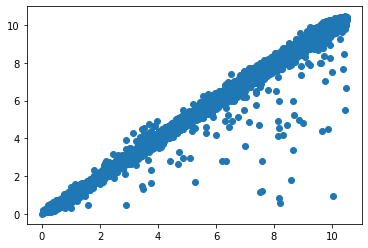

In [7]:
plt.scatter(
    p, 
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)